In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean
import warnings
import os
import sys
import datetime as dt
import cartopy.crs as ccrs
#from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.ticker as mticker
#warnings.filterwarnings("ignore", category=RuntimeWarning) # ignore runtime warnings; here they arise from attempted operations on all-NaN arrays

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy12MHW/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
region='NPac'

In [3]:
nl = dict(zip( ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2', 'CanESM5', 'GEM5.2-NEMO', 'GEM5-NEMO', 'CanCM4i-IC3',],
               [       11,                 11,         11,           11,              8,            9,        11,            11,          11,            11,])) 
modict={'Jacox':['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 
                        'NASA-GEOSS2S', 'NCEP-CFSv2'],
        'CanSIPSv2':['CanCM4i','GEM-NEMO'],
        'CanSIPSv21':['CanCM4i-IC3','GEM5-NEMO'],
        'CanSIPSv3':['CanESM5','GEM5.2-NEMO'],
        'GFDLNASA':[ 'GFDL-SPEAR','NASA-GEOSS2S'],}
lonW=-170+360
lonE=-110+360
latS=35
latN=65
pextent=[-155, -122, 42, 60]
proj=ccrs.Orthographic(central_longitude=-142, central_latitude=50, globe=None)

In [4]:
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
clim_years = [1991, 2020]
years=clim_years
mhwdir = basepath+'/mhw/detrended';
f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{clim_years[0]}_{clim_years[-1]}.nc'
fobs=xr.open_dataset(f_obs,chunks={'time':1,'X':-1,'Y':-1}).sel(X=slice(lonW,lonE),Y=slice(latS,latN))
mods=modict['CanSIPSv3']
ffor={};mhwfor={}
for il in range(0,9):
    flist=[]
    for modi in mods:
        if il<nl[modi]:
            # Load MHWs
            f_in = f'{mhwdir}/mhw_{modi}_l{il}_detrended_{clim_years[0]}_{clim_years[1]}.nc'
            flist.append(f_in)
    ffor[il]=xr.open_mfdataset(flist,chunks={'time':1,'X':-1,'Y':-1,'M':-1},
                                concat_dim='M',combine='nested',data_vars='minimal', coords='minimal',parallel=True,
                preprocess=lambda f: f.drop_vars(["sst_an_thr","mhw_prob"])).sel(X=slice(lonW,lonE),Y=slice(latS,latN))
    M=40
    mhwfor[il]=ffor[il].is_mhw.data[:(-1*il),...].sum(axis=1)/M if il>0 else ffor[il].is_mhw.data.sum(axis=1)/M
mhwobs=fobs.is_mhw.data
lm=mhwobs.sum(axis=0)==0
area=np.cos(np.pi/180*np.ones(np.shape(mhwobs[0,...]))*np.expand_dims(fobs.lat.values,axis=1))*111.3**2

In [5]:
# ice mask
f_ice=basepath+f'/OISST/oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
#with xr.open_dataset(f_ice) as fice:
fice=xr.open_dataset(f_ice).sel(X=slice(lonW,lonE),Y=slice(latS,latN))
icemask1=np.nanmax(fice.ice.data,axis=0)>0
Athresh=.50
Tthresh=.9
#Amax=np.zeros((20,)+np.shape(icemask1))
# for ind in range(0,20):
#     Amax[ind,...]=np.nanmax(fice.ice.data[12*ind:12*(ind+1),...],axis=0)
lost=np.where(fice.ice>Athresh,1,0).sum(axis=0)
#AmaxH=np.mean(np.where(Amax>0,1,0),axis=0)
imask=lost>(1-Tthresh)*np.shape(fice.ice)[0]

/tmp/reo000/998158/ipykernel_2475805/2453365123.py:5: RuntimeWarning: All-NaN slice encountered
  icemask1=np.nanmax(fice.ice.data,axis=0)>0


In [6]:
imin=np.argmin(np.abs(ffor[0].lon.values-(-150+360)))
jmin=np.argmin(np.abs(ffor[0].lat.values-45))
imin,jmin

(np.int64(20), np.int64(10))

In [7]:
A1mask=~lm
A1mask[:jmin,:]=0
A1mask[:,:imin]=0

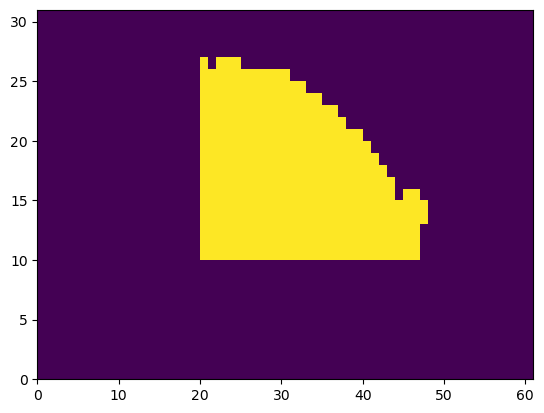

In [8]:
plt.pcolormesh(A1mask)

In [9]:
feez=xr.open_dataset('eezmask.nc').sel(X=slice(lonW,lonE),Y=slice(latS,latN))
eezmask=feez.eezmask.astype(int)
feez.close()
eezmask
A2mask=eezmask&~lm # ocean points only

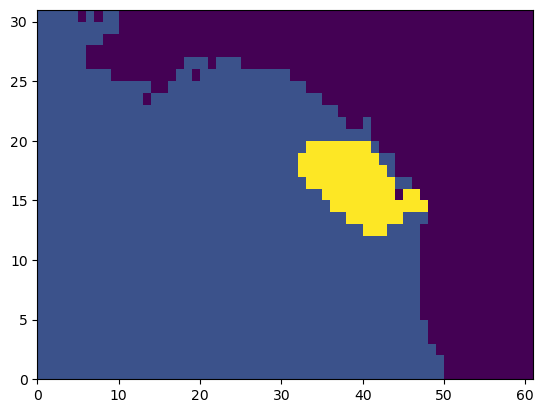

In [10]:
plt.pcolormesh(eezmask-(lm-1)+2*A2mask)

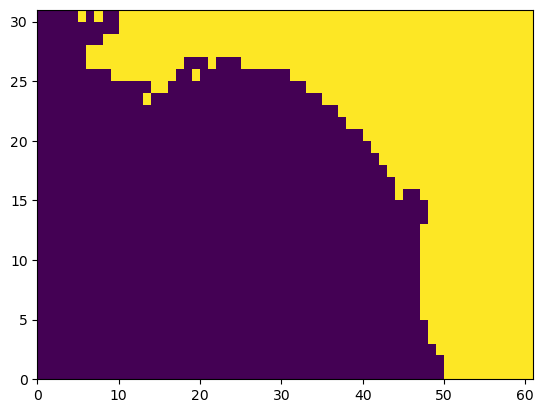

In [11]:
plt.pcolormesh(lm)

In [12]:
area=np.cos(np.pi/180*np.ones(np.shape(mhwobs[0,...]))*np.expand_dims(fobs.lat.values,axis=1))*111.3**2
box1=[-67,-43,42,50]
box2=[-64,-43,51,65]
area1=np.zeros(np.shape(area))
area2=np.zeros(np.shape(area))
area1=area*A1mask
area2=area*A2mask

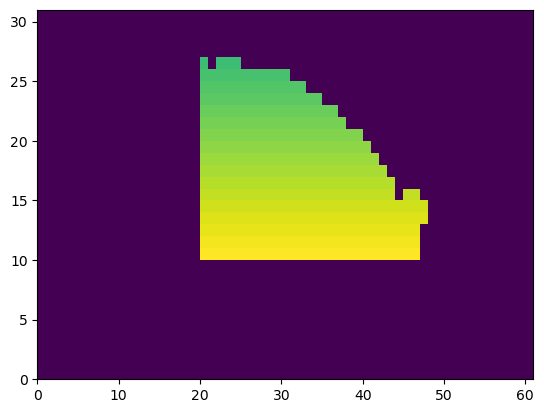

In [13]:
plt.pcolormesh(area1)

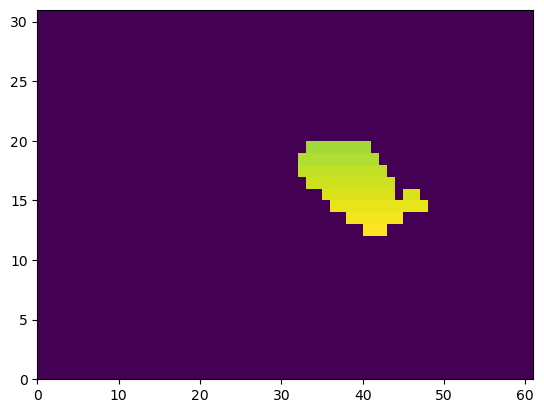

In [14]:
plt.pcolormesh(area2)

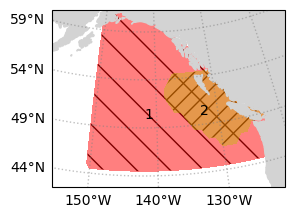

In [15]:
fig = plt.figure(figsize=[3, 3])
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(pextent, ccrs.PlateCarree())

# ax.pcolormesh(fobs.lon.values,fobs.lat.values,A1mask,vmin=.5,vmax=1.5,
#               transform=ccrs.PlateCarree(),shading='nearest')
cs = ax.contourf(fobs.lon.values,fobs.lat.values, A1mask, [.5,1.5],hatches=['\\'],alpha=0,
                 transform=ccrs.PlateCarree(),)
cs = ax.contourf(fobs.lon.values,fobs.lat.values, A2mask, [.5,1.5],hatches=['//'],alpha=0,
                 transform=ccrs.PlateCarree(),)
cs = ax.contourf(fobs.lon.values,fobs.lat.values, A1mask, [.5,1.5],colors=['r',],linestyles='-',alpha=.5,
                 transform=ccrs.PlateCarree(),)
cs = ax.contourf(fobs.lon.values,fobs.lat.values, A2mask, [.5,1.5],colors=['y',],linestyles='-',alpha=.4,
                 transform=ccrs.PlateCarree(),)
ax.text(-142,50,'1',transform=ccrs.PlateCarree())
ax.text(-133,50,'2',transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND,zorder=1,color='lightgray')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlocator = mticker.FixedLocator([-150, -140, -130,-120,])
gl.ylocator = mticker.FixedLocator([44,49,54,59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False


In [16]:
Area1=np.nansum(A1mask*area)
Area2=np.nansum(A2mask*area)

In [17]:
dfAlist=[pd.read_csv(f'figs/dfA_{region}_y{yy}.csv',index_col=0) for yy in range(years[0],years[-1]+1)]
dfA=pd.concat(dfAlist,ignore_index=True)
dfA

,year,month,A1_obs,A2_obs,A1_lag0_weighted,A2_lag0_weighted,A1_lag0_gt1,A2_lag0_gt1,A1_lag0_gt5,A2_lag0_gt5,...,A1_lag8_gt21,A2_lag8_gt21,A1_lag8_gt25,A2_lag8_gt25,A1_lag8_gt29,A2_lag8_gt29,A1_lag8_gt33,A2_lag8_gt33,A1_lag8_gt37,A2_lag8_gt37
0,1991,1,300381.283004,0.000000,242986.092281,0.000000,4.514159e+05,0.000000,3.707291e+05,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991,2,302531.946301,0.000000,187180.571791,0.000000,5.309226e+05,0.000000,3.441133e+05,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1991,3,347632.371698,0.000000,433514.794772,0.000000,9.503919e+05,0.000000,7.284284e+05,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991,4,89340.291560,0.000000,139026.647336,0.000000,8.818925e+05,0.000000,3.290124e+05,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1991,5,8448.384265,0.000000,74211.579020,8877.247153,1.352773e+06,177872.433134,1.383612e+05,7962.653645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2020,8,244314.997731,23721.133204,122507.585467,5606.737997,1.325451e+06,32179.419035,3.223166e+05,24052.363162,...,85568.630026,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
356,2020,9,756386.068125,214728.069403,573086.914032,74015.805175,1.700073e+06,467260.853240,1.208792e+06,290198.818407,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
357,2020,10,454574.123839,137960.841674,606509.128776,249104.369512,1.884421e+06,504012.682709,1.178594e+06,404887.432527,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358,2020,11,280090.059971,15925.307289,350190.984960,15044.486540,1.174924e+06,171943.633903,8.875011e+05,66466.212104,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
cmap = mpl.colormaps['jet']
colors = cmap(np.linspace(0, 1, 40))
styles=['-','--','-.',':']
dates=np.array([dt.datetime(yy,mm,15) for ind,(yy,mm) in dfA[['year','month']].iterrows()])

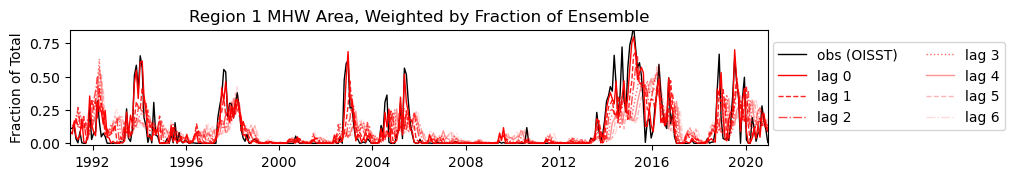

In [19]:
fig,ax=plt.subplots(1,1,figsize=(9,1.5))
ax.plot(dates,dfA.A1_obs/Area1,'k-',label='obs (OISST)',lw=1)
for il in range(0,7):
    ax.plot(dates,dfA[f'A1_lag{il}_weighted']/Area1,'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'lag {il}',lw=1)#marker='.',
ax.set_title('Region 1 MHW Area, Weighted by Fraction of Ensemble')
ax.set_ylabel('Fraction of Total')
ax.legend(loc=1,bbox_to_anchor=[1.35,.95],ncols=2)
ax.set_xlim([dates[0],dates[-1]])
ax.set_ylim([-.015,.85])
fig.savefig('figs/MHWAreaFrac_{region}Region1_weighted.png',bbox_inches='tight',transparent=True)

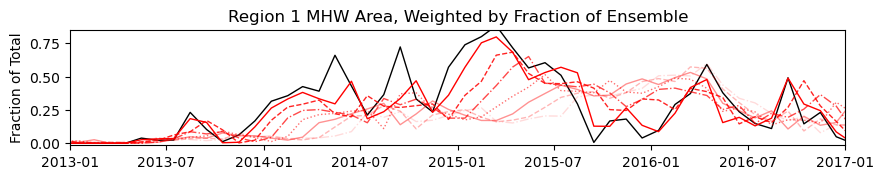

In [20]:
fig,ax=plt.subplots(1,1,figsize=(10,1.5))
ax.plot(dates,dfA.A1_obs/Area1,'k-',label='obs',lw=1)
for il in range(0,7):
    ax.plot(dates,dfA[f'A1_lag{il}_weighted']/Area1,'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'P weighted, lag {il}',lw=1)#
ax.set_title('Region 1 MHW Area, Weighted by Fraction of Ensemble')
ax.set_ylabel('Fraction of Total')
#ax.legend(loc=1,bbox_to_anchor=[1.3,1.1])
ax.set_xlim([dt.datetime(2013,1,1),dt.datetime(2017,1,1)])
ax.set_ylim([-.015,.85])
fig.savefig('figs/MHWAreaFrac_{region}Region1_weightedZoom.png',bbox_inches='tight')

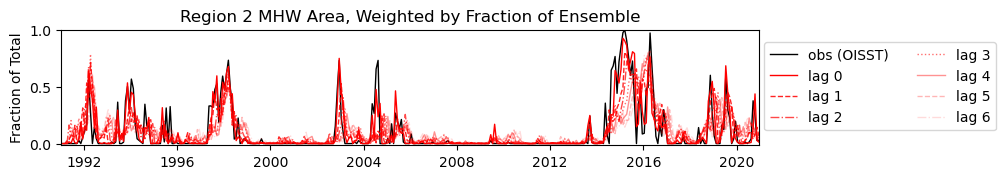

In [21]:
fig,ax=plt.subplots(1,1,figsize=(9,1.5))
ax.plot(dates,dfA.A2_obs/Area2,'k-',label='obs (OISST)',lw=1)
for il in range(0,7):
    ax.plot(dates,dfA[f'A2_lag{il}_weighted']/Area2,'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'lag {il}',lw=1)#marker='.',
ax.set_title('Region 2 MHW Area, Weighted by Fraction of Ensemble')
ax.set_ylabel('Fraction of Total')
ax.legend(loc=1,bbox_to_anchor=[1.35,.95],ncols=2)
ax.set_xlim([dates[0],dates[-1]])
ax.set_ylim([-.015,1])
fig.savefig('figs/MHWAreaFrac_{region}Region2_weighted.png',bbox_inches='tight',transparent=True)

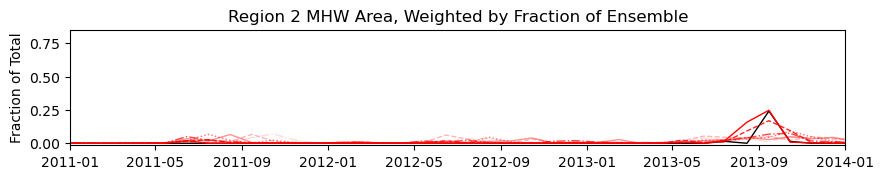

In [22]:
fig,ax=plt.subplots(1,1,figsize=(10,1.5))
ax.plot(dates,dfA.A2_obs/Area2,'k-',label='obs',lw=1)
for il in range(0,7):
    ax.plot(dates,dfA[f'A2_lag{il}_weighted']/Area2,'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'P weighted, lag {il}',lw=1)#
ax.set_title('Region 2 MHW Area, Weighted by Fraction of Ensemble')
ax.set_ylabel('Fraction of Total')
#ax.legend(loc=1,bbox_to_anchor=[1.3,1.1])
ax.set_xlim([dt.datetime(2011,1,1),dt.datetime(2014,1,1)])
ax.set_ylim([-.015,.85])
fig.savefig('figs/MHWAreaFrac_{region}Region2_weightedZoom.png',bbox_inches='tight')

### Reliability

In [23]:
# Region 1
iP0=20;iP1=-10;jP0=10 # cutoff at beginning of arrays to match parametric area

In [24]:
def getcounts(il):
    MHW_all=mhwfor[il][:,jP0:,iP0:iP1]
    omhw=mhwobs[il:,jP0:,iP0:iP1]
    MHW_prob=np.ma.masked_where(np.tile(A1mask[jP0:,iP0:iP1]*np.logical_or(lm[jP0:,iP0:iP1],imask[jP0:,iP0:iP1]),(360-il,1,1))==1,MHW_all*40)
    mcount=[]
    ocount=[]
    ips=np.arange(0,41)
    for ip in ips:
        ind=MHW_prob==ip
        msum=np.sum(ind)
        osum=np.sum(omhw[ind])
        mcount.append(msum)
        ocount.append(osum)
    mcount=np.array(mcount)
    ocount=np.array(ocount)
    return mcount, ocount

In [25]:
mcounts={}
ocounts={}
for il in (0,1,3,6):
    mcounts[il],ocounts[il]=getcounts(il)

In [26]:
ips=np.arange(0,41)
cols={0:'red',1:'darkorange',3:'gold',6:'darkcyan',10:'purple'}

/tmp/reo000/998158/ipykernel_2475805/1726382533.py:4: RuntimeWarning: invalid value encountered in divide
  ax.plot(ips/40,ocounts[il]/mcounts[il],'*',color=cols[il],label=f"{il+.5} Months Lead")
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


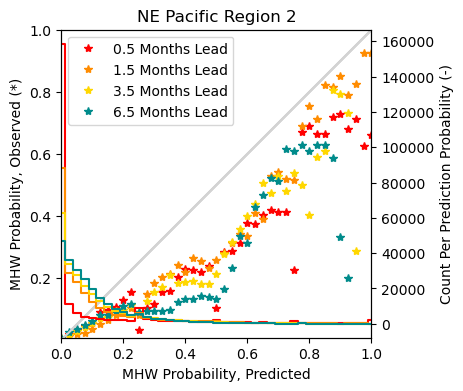

In [27]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
axb=ax.twinx()
for il in (0,1,3,6):
    ax.plot(ips/40,ocounts[il]/mcounts[il],'*',color=cols[il],label=f"{il+.5} Months Lead")
    ax.set_aspect(1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1.008)
    ax.plot([0,1],[0,1],'-',color='lightgray')
    ax.set_xticks([0,.2,.4,.6,.8,1])
    ax.set_yticks([.2,.4,.6,.8,1.])
    axb.step(ips/40,mcounts[il],cols[il],where='mid')
    #axb.set_yscale('log')
ax.legend(fontsize=10)
ax.set_xlabel('MHW Probability, Predicted')
ax.set_ylabel('MHW Probability, Observed (*)')
axb.set_ylabel('Count Per Prediction Probability (-)')
ax.set_title('NE Pacific Region 2')
fig.savefig(f'Rel{region}.png',dpi=600,bbox_inches='tight')

In [28]:
fPXGF={}
for il in (0,1,3,6):
    fPXGF[il]=xr.open_dataset(f'/space/hall5/sitestore/eccc/crd/ccrn/users/rjj000/s2d_calibration/MHW_lead{il}/Data/PXGF-PE_lead{il}.nc')

In [ ]:
fPXGF[3].sst_an_dt[1,:,:,:,:]

In [30]:
np.shape(mhwobs)

(360, 31, 61)

In [31]:
def getcountsP(il):
    MHW_all=fPXGF[il].sst_an_dt[1,:,:,:,:].data
    omhw=mhwobs[:,jP0:,iP0:iP1]
    MHW_prob=np.ma.masked_where(np.expand_dims((A1mask[jP0:,iP0:iP1]*np.logical_or(lm[jP0:,iP0:iP1],imask[jP0:,iP0:iP1])),[2,3])*np.ones((21,31,12,int(360/12)))==1,MHW_all*40)
    print(np.shape(omhw),np.shape(MHW_prob))
    mcount=[]
    ocount=[]
    ips=np.arange(0,41)
    for ip in ips:
        msum=0
        osum=0
        for ii in range(0,np.shape(omhw)[0]):
            ind=(MHW_prob[:,:,ii%12,int(ii/12)]>ip-.5)&(MHW_prob[:,:,ii%12,int(ii/12)]<=ip+.5)
            msum=msum+np.sum(ind)
            osum=osum+np.sum(omhw[ii,...][ind])
        mcount.append(msum)
        ocount.append(osum)
    mcount=np.array(mcount)
    ocount=np.array(ocount)
    return mcount, ocount

In [32]:
mcountsP={}
ocountsP={}
for il in (0,1,3,6):
    mcountsP[il],ocountsP[il]=getcountsP(il)

(360, 21, 31) (21, 31, 12, 30)
(360, 21, 31) (21, 31, 12, 30)
(360, 21, 31) (21, 31, 12, 30)
(360, 21, 31) (21, 31, 12, 30)


/tmp/reo000/998158/ipykernel_2475805/1184076411.py:6: RuntimeWarning: invalid value encountered in divide
  ax.plot(ips/40,ocounts[il]/mcounts[il],'*',color=cols[il],label=f"{il+.5} Months Lead")
/tmp/reo000/998158/ipykernel_2475805/1184076411.py:22: RuntimeWarning: invalid value encountered in divide
  ax1.plot(ips/40,ocountsP[il]/mcountsP[il],'*',color=cols[il],label=f"{il+.5} Months Lead")


Text(0.5, 1.0, 'NE Pacific Region 1 Parametric, Calibrated')

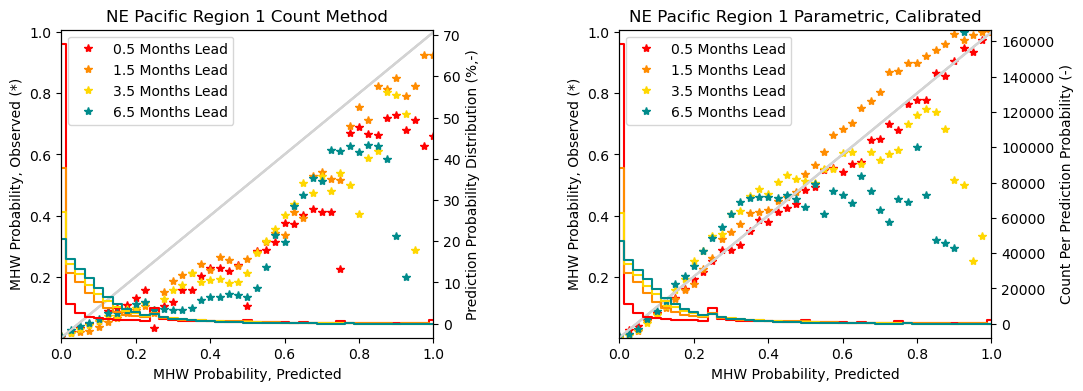

In [37]:
fig,axs=plt.subplots(1,2,figsize=(12,4),gridspec_kw={'wspace':.5})
ax=axs[0]
ax1=axs[1]
axb=ax.twinx()
for il in (0,1,3,6):
    ax.plot(ips/40,ocounts[il]/mcounts[il],'*',color=cols[il],label=f"{il+.5} Months Lead")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1.008)
    ax.plot([0,1],[0,1],'-',color='lightgray')
    ax.set_xticks([0,.2,.4,.6,.8,1])
    ax.set_yticks([.2,.4,.6,.8,1.])
    axb.step(ips/40,mcounts[il]/np.sum(mcounts[il])*100,cols[il],where='mid')
ax.legend(fontsize=10)
ax.set_xlabel('MHW Probability, Predicted')
ax.set_ylabel('MHW Probability, Observed (*)')
axb.set_ylabel('Prediction Probability Distribution (%,-)')
ax.set_title('NE Pacific Region 1 Count Method')


axb1=ax1.twinx()
for il in (0,1,3,6):
    ax1.plot(ips/40,ocountsP[il]/mcountsP[il],'*',color=cols[il],label=f"{il+.5} Months Lead")
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1.008)
    ax1.plot([0,1],[0,1],'-',color='lightgray')
    ax1.set_xticks([0,.2,.4,.6,.8,1])
    ax1.set_yticks([.2,.4,.6,.8,1.])
    axb1.step(ips/40,mcounts[il],cols[il],where='mid')
ax1.legend(fontsize=10)
ax1.set_xlabel('MHW Probability, Predicted')
ax1.set_ylabel('MHW Probability, Observed (*)')
axb1.set_ylabel('Count Per Prediction Probability (-)')
ax1.set_title('NE Pacific Region 1 Parametric, Calibrated')

#fig.savefig(f'Rel{region}.png',dpi=600,bbox_inches='tight')

In [34]:
plt.plot(MHW_all[12,...],MHW_allP[:,:,0,1],'k.')

NameError: name 'MHW_all' is not defined